In [174]:
import os
import random
import numpy as np
print("hello")
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

hello


In [175]:
#HYPERPARAMETERS

epochs = 10
batch_size = 16
margin = 1 # margin for contrastive loss

# Stworzenie ścieżek do odpowiednich zdjęć

In [176]:
class ContrastiveGenerator:
    def __init__(self, datasetPath, number_of_pairs):       #number_of_pairs : number of iterations in loop next_get_item()
        # empty list that will contain the subdirectory names of products
        # of the dataset directory with more than one image in it
        self.types_of_products = list()
        self.number_of_pairs = number_of_pairs

        #iterate over subdirectories in the main directory:
        for folderName in os.listdir(datasetPath):
            # if os.path.isdir(os.path.join(datasetPath, folderName)):
            #     for filename in os.listdir(os.path.join(datasetPath, folderName)):
            #         absoluteFolderName = datasetPath + "/" + folderName + "/" + filename
            #         numImages = len(os.listdir(absoluteFolderName))
            #         if numImages > 1:
            #             self.types_of_products.append(absoluteFolderName)
            # else:
            absoluteFolderName = os.path.join(datasetPath, folderName) #datasetPath + "/" + folderName
            # get the number of images in the subdirectory
            numImages = len(os.listdir(absoluteFolderName))
            if numImages > 1:
                self.types_of_products.append(absoluteFolderName)

        # create a dictionary of people name to their image names
        self.allProducts = self.generate_all_products_dict()


    # Budowanie ścieżek do konkretnych zdjęć
    def generate_all_products_dict(self):
        # create an empty dictionary that will be populated with
        # directory names as keys and image names as values
        all_products = dict()
        for product in self.types_of_products:
            image_names = os.listdir(product)
            # build the image paths and populate the dictionary
            productsPhotos = [os.path.join(product, imageName) for imageName in image_names]
            all_products[product] = productsPhotos
        print(len(all_products))
        #print(all_products)
        return all_products

    def get_next_element(self):
        for i in range(self.number_of_pairs):
            anchor = random.choice(self.types_of_products)

            # copy the list of products
            temporaryImages = self.types_of_products.copy()
            temporaryImages.remove(anchor)

            # random product from a list of products without anchor
            negativeProduct = random.choice(temporaryImages)

            (anchorProduct, positiveProduct) = np.random.choice(
                a=self.allProducts[anchor],
                size=2,
                replace=False
            )
            # Image from the negative folder
            negativeProduct = random.choice(self.allProducts[negativeProduct])

            # anchor = tf.convert_to_tensor(anchor)
            # positiveProduct = tf.convert_to_tensor(positiveProduct)
            # negativeProduct = tf.convert_to_tensor(negativeProduct)

            yield (anchorProduct, positiveProduct, 0.0)
            yield (anchorProduct, negativeProduct, 1.0)

# Stworznie obiektu do generowania zestawów danych

In [177]:
path = r"Fruits_test"
number_of_samples = 2
generator = ContrastiveGenerator(path, number_of_samples)
# for positive_pair, negative_pair in generator.get_next_element():
#     print(positive_pair)
#     print(negative_pair)

    
    

6


# Generator do tworzenia datasetu

In [178]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

In [179]:
print(dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


# Tworzenie zbioru danych


In [180]:
IMAGE_SIZE = (258, 320)



def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    #img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_resize_wrapper(image_path1, image_path2,value):
    # return tf.py_function(decode_and_resize, [image_path], tf.float32)
    img1 = decode_and_resize(image_path1)
    img2 = decode_and_resize(image_path2)
    return (img1, img2), value

def generate_new_pack_of_images():
    list_of_products = []
    
    # Mapowanie funkcji na oba obrazy
    img_pack = dataset.map(lambda image_path1, image_path2, value: (decode_resize_wrapper(image_path1,image_path2,value)) )

    # training = img_pack.map(lambda x, y: (x,y))
    # print(training)
    # return training
    for (img1, img2), value in img_pack:
        list_of_products.append( ((img1, img2),value.numpy() ) )
        
    return list_of_products

# print(list_of_products[0])
# print(len(list_of_products))


# Stworznie nowej paczki zdjęć z etykietami

In [191]:
list_of_products = generate_new_pack_of_images()
# print(list_of_products[0])

X = np.array([item[:-1] for item in list_of_products])
y = np.array([item[-1] for item in list_of_products])
print(X)

[[[[[[0.40000004 0.40784317 0.4039216 ]
     [0.43921572 0.45098042 0.4431373 ]
     [0.41960788 0.427451   0.43921572]
     ...
     [0.10980393 0.16470589 0.16470589]
     [0.12156864 0.1764706  0.16470589]
     [0.1254902  0.18039216 0.17254902]]

    [[0.4431373  0.45882356 0.4431373 ]
     [0.43529415 0.45098042 0.43529415]
     [0.43137258 0.43921572 0.454902  ]
     ...
     [0.10980393 0.16470589 0.16470589]
     [0.12156864 0.1764706  0.16470589]
     [0.12156864 0.1764706  0.16470589]]

    [[0.41176474 0.427451   0.4039216 ]
     [0.43921572 0.454902   0.43137258]
     [0.46274513 0.4666667  0.49803925]
     ...
     [0.10588236 0.16078432 0.16078432]
     [0.11764707 0.17254902 0.16078432]
     [0.10980393 0.16470589 0.15686275]]

    ...

    [[0.27450982 0.34509805 0.4039216 ]
     [0.27058825 0.34117648 0.40000004]
     [0.27450982 0.34509805 0.4039216 ]
     ...
     [0.34901962 0.35686275 0.3137255 ]
     [0.34901962 0.35686275 0.3137255 ]
     [0.35686275 0.36862746 0

2024-03-25 10:00:47.442251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## wyświetlamy i sprawdzamy czy jest wszystko ok

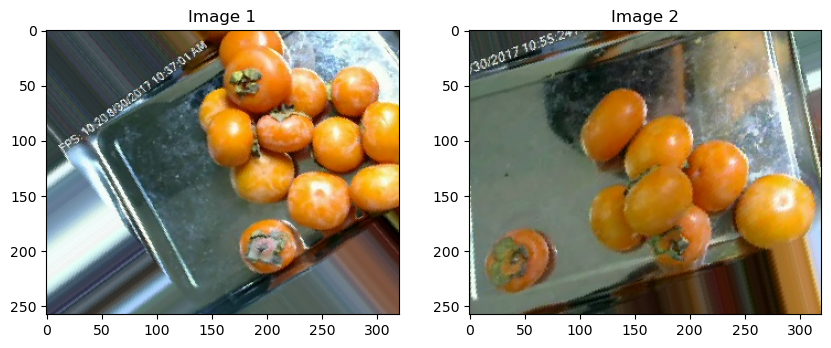

Etykieta: 0.0


In [182]:
# wyświetlenie obrazów:
import numpy
(img1, img2), label = list_of_products[0]

plt.figure(figsize=(10, 5))

# Obraz 1
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
# Obraz 2
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.show()
print("Etykieta:", label)

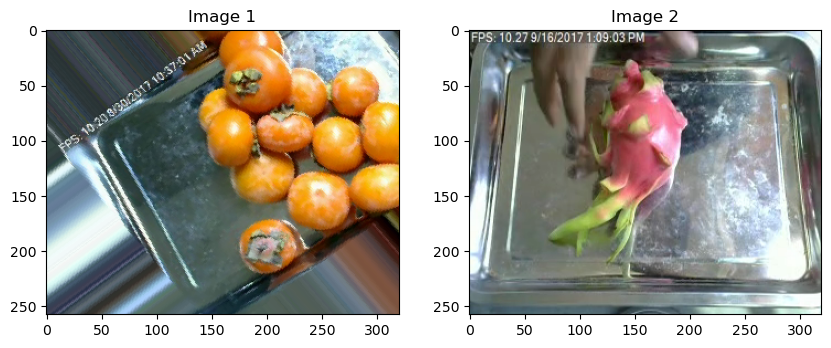

Etykieta: 1.0


In [183]:
(img1, img2), label = list_of_products[1]

# Wyświetlenie obrazów
plt.figure(figsize=(10, 5))
# Obraz 1
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
# Obraz 2
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')

plt.show()
print("Etykieta:", label)

# Model do nauki rozróżniania produktów

In [184]:
import keras

def euclidean_distance(vects):
    """
    Znalezienie odległości euklidesowej pomiędzy dwoma wektorami:

    Arguments:
        vects: Lista zawierające dwa tensory tej samej długości

    Returns:
        Tensor containing euclidean distance pomiędzy podanymi wektorami
    """
    x, y = vects

    sum_square = ops.sum(ops.square(x-y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))


input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu

input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Definicja funkcji straty

In [185]:
def loss(margin=1):
    """
    Arguments: 
        margin: Integer, defines the baseline for distance for which pairs
        shoud be classified as dissimilar "1"
    Returns:
        tensor with contrastive loss as floating point value
    """
    # 0-same ,  1-different
    
    #contrastive_loss = (1-y_true)*

    def contrastive_loss(y_true, y_pred):
        """Calculate the contrastive loss
        Arguments:
            y_true: List of labels, each label is of type "float32"
            y_pred: List of predictions
            y_pred to przewidywane odległości między parami danych, które model stara się nauczyć
        Returns:
            A tensor containing contrastive loss value (folat)
        """
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss
    

## kompilacja modelu z contrastive loss


In [186]:
# Kompilacja modelu z contrastive_loss

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_32      │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_41       │ (None, 10)        │  2,118,326 │ input_layer_31[0… │
│ (Functional)        │                   │            │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1)         │          0 │ functional_41[0]… │
│                     │                   │            │ functional_41[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,118,332 (8.08 MB)

 Trainable params: 1,817,716 (6.93 MB)

 Non-trainable params: 300,616 (1.15 MB)

In [187]:
# train_products_list = list_of_products[:(int)(0.8*2*number_of_samples)]
# val_products_list = list_of_products[(int)(0.8*2*number_of_samples) :]

# print(len(train_products_list))
# print(len(val_products_list))

# x_train_1 = []
# x_train_2 = []
# labels_train = []
# x_val_1 = []
# x_val_2 = []
# labels_val = []
# for (img1, img2), label in train_products_list:
#     x_train_1.append(img1)
#     x_train_2.append(img2)
#     labels_train.append(label)
# for (img1, img2), label in val_products_list:
#     x_val_1.append(img1)
#     x_val_2.append(img2)
#     labels_val.append(label)


# print(x_train_1)
# print(labels_train)


siamese.fit( X, y, 
            validation_split= 0.2, 
            batch_size = batch_size,
            epochs = epochs
           )

Epoch 1/10


ValueError: Layer 'functional_43' expected 2 input(s). Received 1 instead.